<h1> Test des modèles</H1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time
import pickle
import dill
import myfunctions as myf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os
from IPython.display import clear_output

# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [2]:
# Lancement de Mlflow
import mlflow
from mlflow.models import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
# Démarrer le serveur MLflow
mlflow_process = myf.start_mlflow_server()
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("projet_7_test_1")

<Experiment: artifact_location='/home/jul/OpenClassroom/mlflow/913159267105584020', creation_time=1715529309018, experiment_id='913159267105584020', last_update_time=1715529309018, lifecycle_stage='active', name='projet_7_test_1', tags={}>

In [3]:
df = pd.read_csv('data/tweets_tokenized_test_1.csv')

# Prédictions simples

## TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#### Test des différentes tokenization

In [6]:
def regression_tfidf(df, column) :
    X = df[column]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
    X_train = tfidf.fit_transform(X_train)
    X_test = tfidf.transform(X_test)


    model_params ={
        'max_iter': 1000,
        'solver': 'saga',
        'penalty': 'l2'
    }
    lr = LogisticRegression(**model_params)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [7]:
columns = ['hash', 'no_hash', 'hash_lem', 'no_hash_lem']
for column in columns :
    print(f'Formatage : {column}')
    print()
    regression_tfidf(df, column)
    print()
    print('--------------------------------------------')
    print()

Formatage : hash

[[1144  449]
 [ 390 1203]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1593
           1       0.73      0.76      0.74      1593

    accuracy                           0.74      3186
   macro avg       0.74      0.74      0.74      3186
weighted avg       0.74      0.74      0.74      3186


--------------------------------------------

Formatage : no_hash

[[1144  449]
 [ 390 1203]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1593
           1       0.73      0.76      0.74      1593

    accuracy                           0.74      3186
   macro avg       0.74      0.74      0.74      3186
weighted avg       0.74      0.74      0.74      3186


--------------------------------------------

Formatage : hash_lem

[[1127  466]
 [ 405 1188]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1593
 

#### Tokenization choisie

In [8]:
X = df['hash']
y = df['label']

# Séparer les données en ensemble de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectoriser les tweets
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Créer et entrainer le modèle
model_params ={
    'max_iter': 1000,
    'solver': 'saga',
    'penalty': 'l2'
}
lr = LogisticRegression(**model_params)
lr.fit(X_train, y_train)

# Prédire les labels et enregistrer le temps de prédiction
start_time = time.time()
y_pred = lr.predict(X_test)
prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

# Afficher les résultats
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

[[1144  449]
 [ 390 1203]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1593
           1       0.73      0.76      0.74      1593

    accuracy                           0.74      3186
   macro avg       0.74      0.74      0.74      3186
weighted avg       0.74      0.74      0.74      3186



In [9]:
model_name = "Logistic_Regression_TfIdf_1"
with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path=model_name,
        signature=signature,
        input_example=X_train,
        registered_model_name=model_name,
    )

Successfully registered model 'Logistic_Regression_TfIdf_1'.
2024/05/12 17:56:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic_Regression_TfIdf_1, version 1
Created version '1' of model 'Logistic_Regression_TfIdf_1'.


## Word2Vec

In [10]:
import gensim
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

### Embedding simple

##### Test avec différents embeddings

In [11]:
def regression_word2vec(df, column):
    X = df[column].apply(lambda x: x.split())  # split documents into words
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # train Word2Vec model
    w2v = Word2Vec(X_train, min_count=1)
    
    # transform documents to vectors
    X_train = X_train.apply(lambda x: np.mean([w2v.wv[word] for word in x], axis=0))
    X_test = X_test.apply(lambda x: np.mean([w2v.wv[word] for word in x if word in w2v.wv] or [np.zeros(w2v.vector_size)], axis=0))

    # convertir en array numpy
    X_train = np.array(X_train.tolist())
    X_test = np.array(X_test.tolist())

    # entrainer le modèle
    model_params ={
        'max_iter': 1000,
        'solver': 'saga',
        'penalty': 'l2'
    }
    lr = LogisticRegression(**model_params)
    lr.fit(list(X_train), y_train)
    
    # Prédire les labels
    y_pred = lr.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [12]:
columns = ['hash', 'no_hash', 'hash_lem', 'no_hash_lem']
for column in columns :
    print(f'Formatage : {column}')
    print()
    regression_word2vec(df, column)
    print()
    print('--------------------------------------------')
    print()

Formatage : hash

[[1006  587]
 [ 836  757]]
              precision    recall  f1-score   support

           0       0.55      0.63      0.59      1593
           1       0.56      0.48      0.52      1593

    accuracy                           0.55      3186
   macro avg       0.55      0.55      0.55      3186
weighted avg       0.55      0.55      0.55      3186


--------------------------------------------

Formatage : no_hash

[[1004  589]
 [ 824  769]]
              precision    recall  f1-score   support

           0       0.55      0.63      0.59      1593
           1       0.57      0.48      0.52      1593

    accuracy                           0.56      3186
   macro avg       0.56      0.56      0.55      3186
weighted avg       0.56      0.56      0.55      3186


--------------------------------------------

Formatage : hash_lem

[[1032  561]
 [ 837  756]]
              precision    recall  f1-score   support

           0       0.55      0.65      0.60      1593
 

##### Embedding choisi

In [13]:
X = df['no_hash_lem'].apply(lambda x: x.split())  # split documents into words
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# train Word2Vec model
w2v = Word2Vec(X_train, min_count=1)

# transform documents to vectors
X_train = X_train.apply(lambda x: np.mean([w2v.wv[word] for word in x], axis=0))
X_test = X_test.apply(lambda x: np.mean([w2v.wv[word] for word in x if word in w2v.wv] or [np.zeros(w2v.vector_size)], axis=0))

# convertir en array numpy
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# Entrainer le modèle
model_params ={
        'max_iter': 1000,
        'solver': 'saga',
        'penalty': 'l2'
    }
lr = LogisticRegression(**model_params)
lr.fit(list(X_train), y_train)

# Prédire les labels et enregistrer le temps de prédiction
start_time = time.time()
y_pred = lr.predict(X_test)
prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

[[1030  563]
 [ 838  755]]
              precision    recall  f1-score   support

           0       0.55      0.65      0.60      1593
           1       0.57      0.47      0.52      1593

    accuracy                           0.56      3186
   macro avg       0.56      0.56      0.56      3186
weighted avg       0.56      0.56      0.56      3186



In [14]:
model_name = "Logistic_Regression_Word2Vec_embedding_simple_1"
with mlflow.start_run(run_name= model_name):
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path=model_name,
        signature=signature,
        input_example=X_train,
        registered_model_name=model_name,
    )

Successfully registered model 'Logistic_Regression_Word2Vec_embedding_simple_1'.
2024/05/12 17:56:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic_Regression_Word2Vec_embedding_simple_1, version 1
Created version '1' of model 'Logistic_Regression_Word2Vec_embedding_simple_1'.


### Embedding plus complexe

In [15]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

2024-05-12 17:56:14.889284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 17:56:15.190543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 17:56:16.080277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Préparation des embeddings

In [16]:
import time

def make_W2V_embeddings(df, col):
    start_time = time.time()
    
    w2v_size=300
    w2v_window=5
    w2v_min_count=1
    w2v_epochs=100
    maxlen = df[col].apply(lambda x : len(x)).max()
    sentences = df[col].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

    # Création et entraînement du modèle Word2Vec
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=os.cpu_count())

    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print('Modèle Word2Vec entraîné. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Préparation des sentences (tokenization)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                        maxlen=maxlen,
                                                        padding='post') 
                                                    
    num_words = len(tokenizer.word_index) + 1
    print('Sentences tokenizées. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création de la matrice d'embedding
    w2v_size = 300
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
        
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    word_rate = np.round(j/i,4)
    print('Matrice d\'embedding créée. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création du modèle
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                            output_dim=w2v_size,)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)
    print('Modèle créé. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création des embeddings
    embeddings = embed_model.predict(x_sentences)
    print('Embeddings créés. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))
    
    return embeddings

##### Choix du preprocessing

In [17]:
def regression_word2vec(df, column):

    embeddings = make_W2V_embeddings(df, column)

    # Train logistic regression
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, test_size=0.2, random_state=42)

    lr = LogisticRegression(max_iter=1000, solver='saga', penalty='l2')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [18]:
columns = ['hash', 'no_hash', 'hash_lem', 'no_hash_lem']
for column in columns :
    print(f'Formatage : {column}')
    print()
    regression_word2vec(df, column)
    print()
    print('--------------------------------------------')
    print()

Formatage : hash

Modèle Word2Vec entraîné. Temps écoulé: 5.35 secondes
Sentences tokenizées. Temps écoulé: 5.44 secondes
Matrice d'embedding créée. Temps écoulé: 7.89 secondes


2024-05-12 17:56:26.369029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 17:56:26.489473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 17:56:26.489525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 17:56:26.493503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 17:56:26.493573: I external/local_xla/xla/stream_executor

Modèle créé. Temps écoulé: 10.06 secondes
 73/498 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step  

I0000 00:00:1715529386.989470   12426 service.cc:145] XLA service 0x7f7380018e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715529386.989504   12426 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-05-12 17:56:27.021829: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715529387.116946   12426 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step
Embeddings créés. Temps écoulé: 10.78 secondes
[[813 780]
 [721 872]]
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      1593
           1       0.53      0.55      0.54      1593

    accuracy                           0.53      3186
   macro avg       0.53      0.53      0.53      3186
weighted avg       0.53      0.53      0.53      3186


--------------------------------------------

Formatage : no_hash

Modèle Word2Vec entraîné. Temps écoulé: 5.51 secondes
Sentences tokenizées. Temps écoulé: 5.71 secondes
Matrice d'embedding créée. Temps écoulé: 8.32 secondes
Modèle créé. Temps écoulé: 8.32 secondes
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
Embeddings créés. Temps écoulé: 8.78 secondes
[[815 778]
 [738 855]]
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1593
           1       0.52      0.54      0.53      1593

    accuracy    

##### Test

In [19]:
embeddings = make_W2V_embeddings(df, 'no_hash_lem')

# Train logistic regression
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

model_params ={
        'max_iter': 1000,
        'solver': 'saga',
        'penalty': 'l2'
    }
lr = LogisticRegression(**model_params)
lr.fit(X_train, y_train)

# Prédire les labels et enregistrer le temps de prédiction
start_time = time.time()
y_pred = lr.predict(X_test)
prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

Modèle Word2Vec entraîné. Temps écoulé: 5.31 secondes
Sentences tokenizées. Temps écoulé: 5.39 secondes
Matrice d'embedding créée. Temps écoulé: 7.79 secondes
Modèle créé. Temps écoulé: 7.80 secondes
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Embeddings créés. Temps écoulé: 8.55 secondes
[[1562    0]
 [1624    0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1562
           1       0.00      0.00      0.00      1624

    accuracy                           0.49      3186
   macro avg       0.25      0.50      0.33      3186
weighted avg       0.24      0.49      0.32      3186



/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [20]:
model_name = "Logistic_Regression_Word2Vec_embedding_complexe_1"
with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path=model_name,
        signature=signature,
        input_example=X_train,
        registered_model_name=model_name,
    )

Successfully registered model 'Logistic_Regression_Word2Vec_embedding_complexe_1'.
2024/05/12 17:57:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic_Regression_Word2Vec_embedding_complexe_1, version 1
Created version '1' of model 'Logistic_Regression_Word2Vec_embedding_complexe_1'.


# Prédictions avancées

In [20]:
from gensim.models import Word2Vec, FastText, KeyedVectors

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential

import keras
from keras.layers import Embedding, Dense, BatchNormalization, Input, Embedding, TextVectorization, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.initializers import Constant
from tensorflow.python.framework import tensor_spec

### Préparation des données

In [5]:
X = df['dl']
y = df['label']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [6]:
X_lem = df['dl_lem']

# Split the data into training, validation, and test sets
X_train_lem, X_temp_lem, y_train_lem, y_temp_lem = train_test_split(X_lem, y, test_size=0.4, stratify=y, random_state=42)
X_val_lem, X_test_lem, y_val_lem, y_test_lem = train_test_split(X_temp_lem, y_temp_lem, test_size=0.5, stratify=y_temp_lem, random_state=42)

### Fonctions

In [7]:
def create_embedding_matrix_fct(embedding_model, X_train, embedding_type):

    # Préparer les datas pour keras
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    X_train_tok = tokenizer.texts_to_sequences(X_train)

    # Normalisation de la taille des séquences
    max_seq_len = max(len(seq) for seq in X_train_tok)
    
    # Choix du modèle d'embedding
    if embedding_type == 'ft':
        model_to_use = embedding_model
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'perso':
        model_to_use = embedding_model.wv
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'glove':
        for word in embedding_model:
            embedding_dim = len(embedding_model[word])
            break

    # Préparation de la matrice d'embedding
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if embedding_type in ['ft', 'perso']:
            if word in model_to_use:
                embedding_matrix[i] = model_to_use[word]
        elif embedding_type == 'glove':
            embedding_vector = embedding_model.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    return embedding_matrix, max_seq_len

In [8]:
def embed_use_batches_fct(data, batch_size):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_embeddings = embedding_model(batch)
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings)

In [11]:
def create_model_fct(lstm, embedding_type, model_name, embedding_matrix, max_seq_len=None):

    # Initialiser le modèle et définir son nom
    model = Sequential(name=model_name)  

    # Ajouter les couches d'embedding
    if embedding_type == 'use':
        model.add(Input(shape=(512,), name=f'input_{model_name}'))
        model.add(tf.keras.layers.Reshape((1, 512)))
    else:
        vocab_size, embedding_dim = embedding_matrix.shape
        model.add(TextVectorization(max_tokens=vocab_size, output_sequence_length=max_seq_len, output_mode='int', name=f'text_vectorization_{model_name}'))
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False, name=f'embedding_{model_name}'))

    # Ajouter une couche lstm
    if lstm == 'lstm':
        model.add(LSTM(256, name=f'lstm_{model_name}'))

    model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01), name=f'dense1_{model_name}'))
    model.add(BatchNormalization(name=f'batch_norm_{model_name}'))
    model.add(Dense(1, activation='sigmoid', name=f'dense2_{model_name}'))

    # Compiler le modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
# Afficher l'évolution des performances lors de l'entrainement
def visualize_history_fct(history):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(history.history['loss'], label='Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [13]:
# Créer un callback
def create_callback_fct(model_save_path, patience=5):
    model_save_path = model_save_path
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
    callbacks_list = [checkpoint, es]

    return callbacks_list, model_save_path

In [14]:
# Voir les résultats sur l'ensemble de test
def test_model_fct(model, X_val, y_val, X_test, y_test, model_save_path):
    # Prédire sur l'ensemble de test avec le meilleur epoch
    model.load_weights(model_save_path)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(val_accuracy))
    print("Validation loss:  {:.4f}".format(val_loss))

    # Prédire sur l'ensemble de test avec le meilleur epoch
    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(test_accuracy))
    print("Test loss:  {:.4f}".format(test_loss))

    # Enregistrer le temps de prédiction
    prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

    return test_accuracy, prediction_time_per_tweet

In [15]:
# Enregistrer dans mlFlow

def register_mlflow_fct(model, accuracy, prediction_time_per_tweet, model_name, X_train, embedding_type=None):
    with mlflow.start_run(run_name=model_name):

        # Enregistrement des paramètres du modèle
        mlflow.log_params(model.get_config())

        # Enregistrement des résultats
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("time per prediction", prediction_time_per_tweet)

        # Définir la signature du modèle
        if embedding_type == 'use':
            signature = infer_signature(X_train, model.predict(X_train))
            # Enregistrement du modèle
            mlflow.keras.log_model(
                model=model,
                artifact_path=model_name,
                signature=signature,
                registered_model_name=model_name,
                )
        else :
            # Enregistrement du modèle
            mlflow.keras.log_model(
                model=model,
                artifact_path=model_name,
                registered_model_name=model_name,
                )


In [16]:
def visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, y_train=y_train, y_val=y_val, y_test=y_test, batch_size=32, epochs=50, lstm=None, embedding_type='perso'):
    

    # Préparer les données et le modèle
    # ---------------------------------------------------------
    if embedding_type == 'use':
        X_train = embed_use_batches_fct(X_train, 64)
        X_val = embed_use_batches_fct(X_val, 64)
        X_test = embed_use_batches_fct(X_test, 64)
        embedding_matrix = None
        max_seq_len = None
        model = create_model_fct(lstm, embedding_type, model_name, embedding_matrix, max_seq_len=max_seq_len)
        
    else :
        # Préparer les données pour keras
        embedding_matrix, max_seq_len = create_embedding_matrix_fct(embedding_model, X_train, embedding_type)
        #créer le modèle
        model = create_model_fct(lstm, embedding_type, model_name, embedding_matrix, max_seq_len=max_seq_len)
        # Initialiser la couche de vectorisation
        model.get_layer(name=f'text_vectorization_{model_name}').adapt(X_train)
        
    # Entrainer le modèle
    # ---------------------------------------------------------

    # Création du callback
    callbacks_list, model_save_path = create_callback_fct("./data/model_best_weights.keras")

    # Train the model
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        batch_size=batch_size, 
        epochs=epochs, 
        callbacks=callbacks_list,
        verbose = 0
        )



    # Visualiser les performances
    # ---------------------------------------------------------

    # Visualiser l'history
    visualize_history_fct(history)

    test_accuracy, prediction_time_per_tweet = test_model_fct(model, X_val, y_val, X_test, y_test, model_save_path)


    if embedding_type == 'use':
        register_mlflow_fct(model, test_accuracy, prediction_time_per_tweet, model_name, X_train, embedding_type='use')
    else :
        register_mlflow_fct(model, test_accuracy, prediction_time_per_tweet, model_name, X_train)
        

## Modèle Keras avec embedding Word2vec

2024-05-13 19:39:09.890882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 19:39:09.911033: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


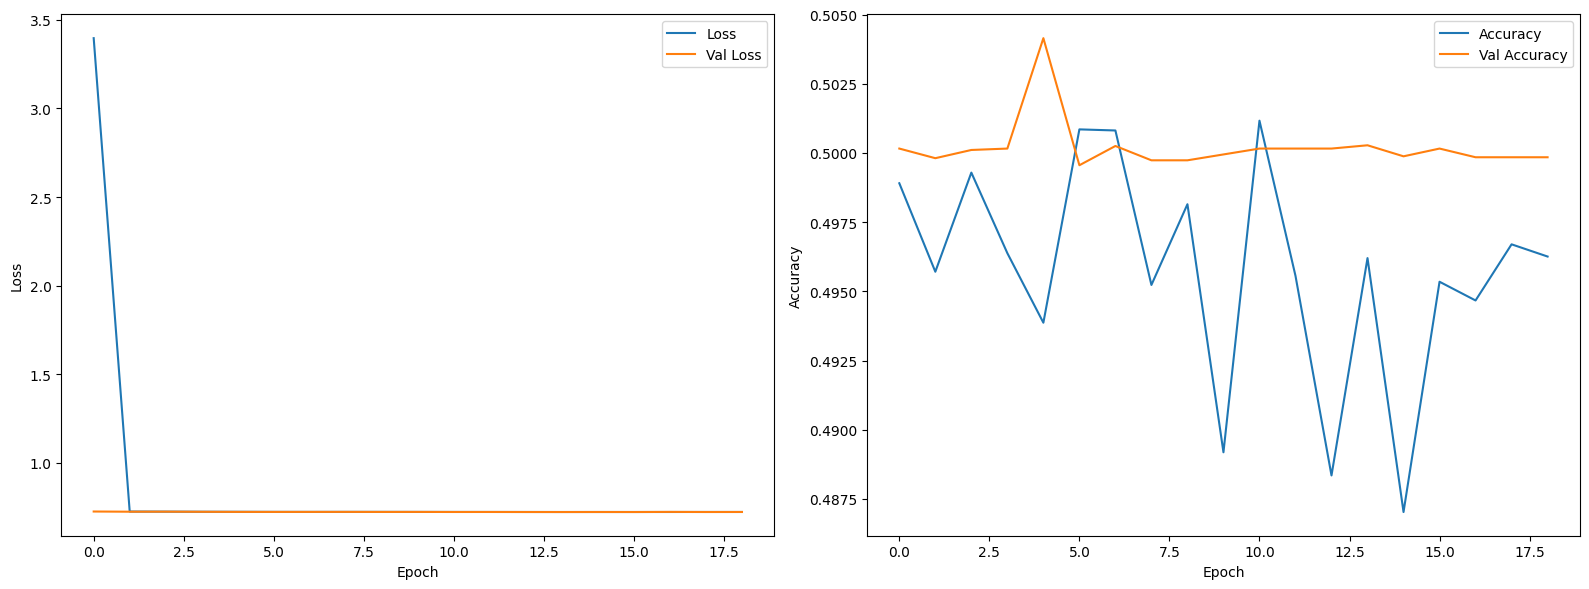

Validation Accuracy :  0.5003
Validation loss:  0.7219
Test Accuracy       :  0.5002
Test loss:  0.7219


2024/05/13 19:39:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/05/13 19:39:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7d78yknk/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_Word2Vec_no_lem_1' already exists. Creating a new version of this model...
2024/05/13 19:39:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Word2Vec_no_lem_1, version 3
Created version '3' of model 'Keras_Word2Vec_no_lem_1'.


In [21]:
model_name = "Keras_Word2Vec_no_lem_1"
embedding_model = Word2Vec(X_train, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test)

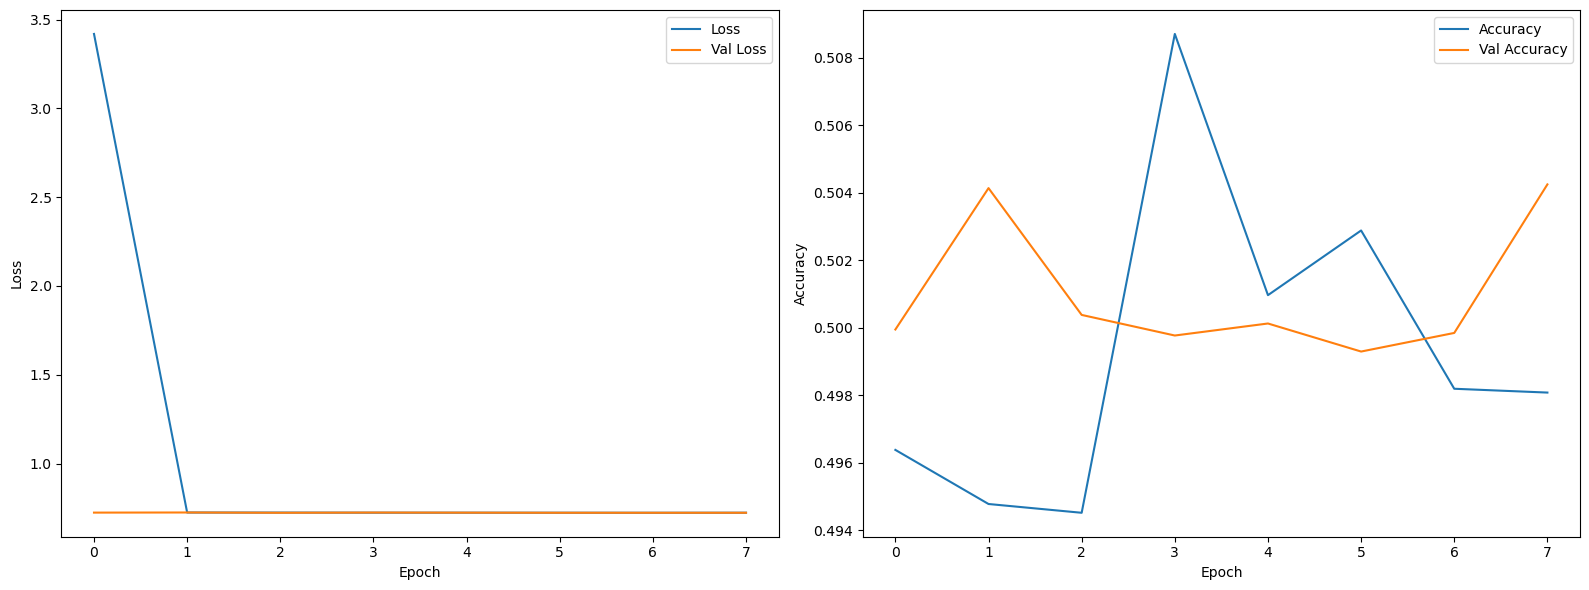

Validation Accuracy :  0.5004
Validation loss:  0.7233
Test Accuracy       :  0.5002
Test loss:  0.7233


2024/05/13 08:44:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 08:44:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpajt4qm7w/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_Word2Vec_with_lem_1' already exists. Creating a new version of this model...
2024/05/13 08:44:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Word2Vec_with_lem_1, version 2
Created version '2' of model 'Keras_Word2Vec_with_lem_1'.


In [16]:
model_name = "Keras_Word2Vec_with_lem_1"
embedding_model = Word2Vec(X_train_lem, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train_lem, X_val_lem, X_test_lem)

2024-05-13 08:44:07.279896: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


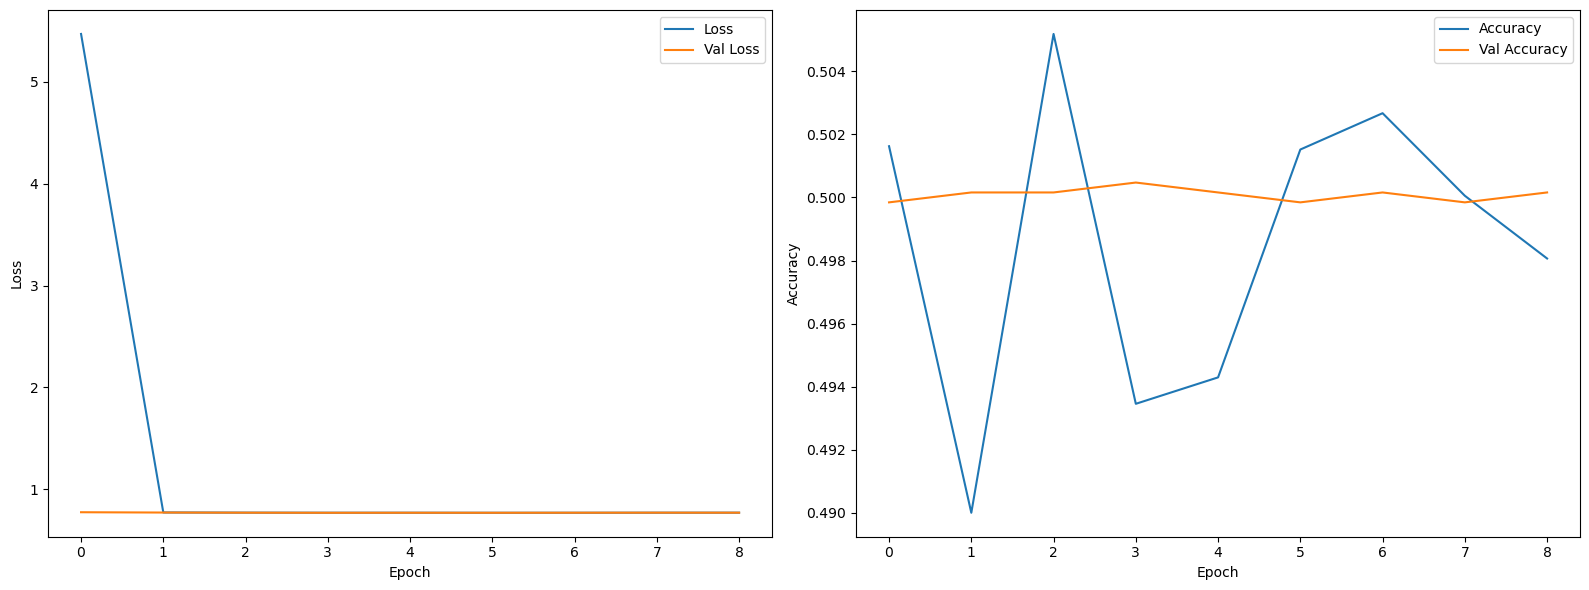

Validation Accuracy :  0.5005
Validation loss:  0.7685
Test Accuracy       :  0.5003
Test loss:  0.7685


2024/05/13 08:44:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 08:44:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpbr54iiwn/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_Word2Vec_no_lem_1' already exists. Creating a new version of this model...
2024/05/13 08:44:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Word2Vec_no_lem_1, version 2
Created version '2' of model 'Keras_lstm_Word2Vec_no_lem_1'.


In [17]:
model_name = "Keras_lstm_Word2Vec_no_lem_1"
embedding_model = Word2Vec(X_train, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm')

## Modèle Keras avec embedding FastText

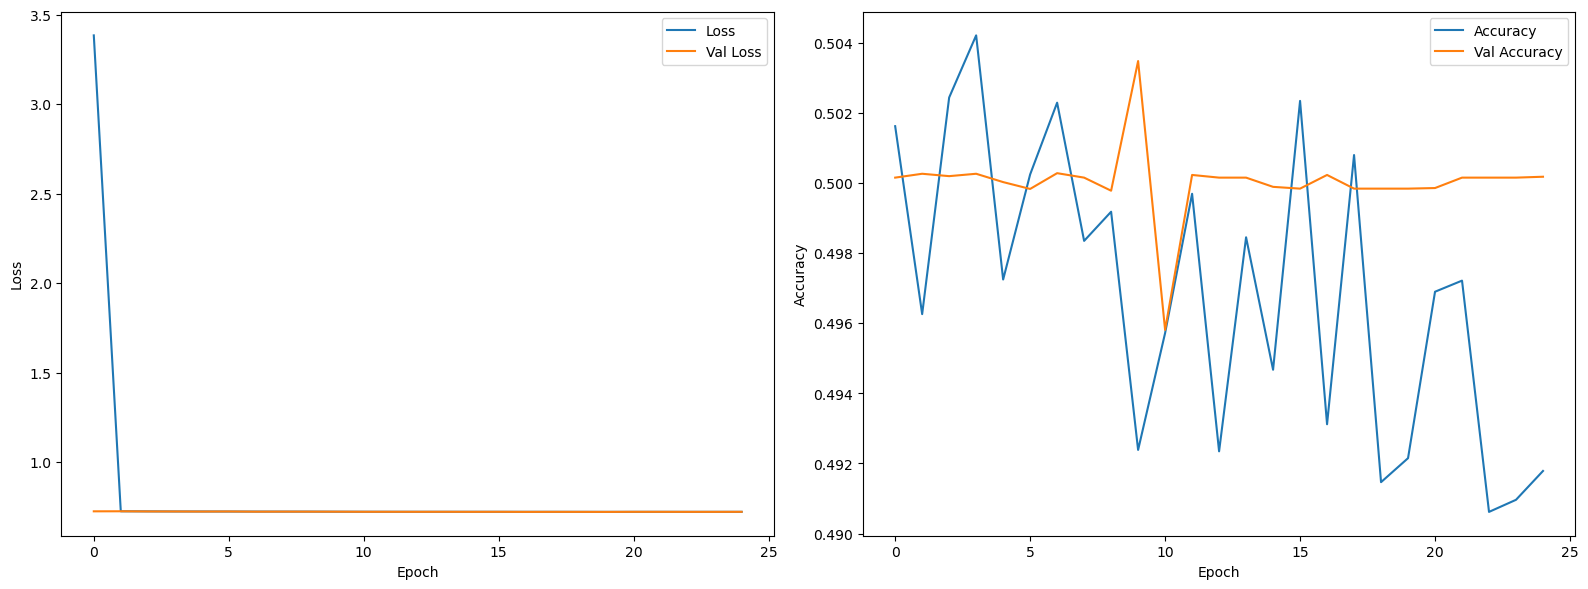

Validation Accuracy :  0.4998
Validation loss:  0.7213
Test Accuracy       :  0.5000
Test loss:  0.7213


2024/05/13 08:46:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 08:46:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp3vl3e1ev/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_FastText_no_lem_1' already exists. Creating a new version of this model...
2024/05/13 08:46:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_FastText_no_lem_1, version 2
Created version '2' of model 'Keras_FastText_no_lem_1'.


In [18]:
model_name = "Keras_FastText_no_lem_1"
embedding_model = FastText(X_train, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test)

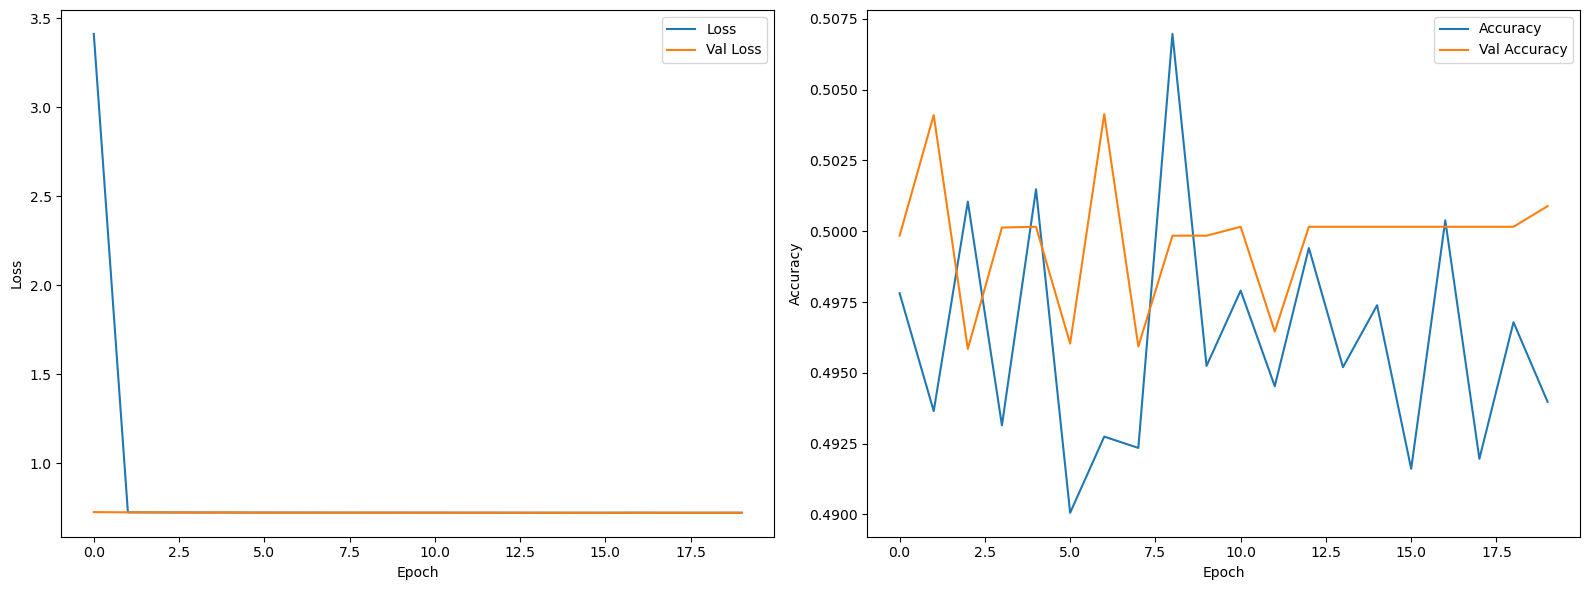

Validation Accuracy :  0.5002
Validation loss:  0.7220
Test Accuracy       :  0.5000
Test loss:  0.7220


2024/05/13 08:47:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 08:47:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmprm2b1ks9/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_FastText_with_lem_1' already exists. Creating a new version of this model...
2024/05/13 08:47:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_FastText_with_lem_1, version 2
Created version '2' of model 'Keras_FastText_with_lem_1'.


In [19]:
model_name = "Keras_FastText_with_lem_1"
embedding_model = FastText(X_train, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train_lem, X_val_lem, X_test_lem)

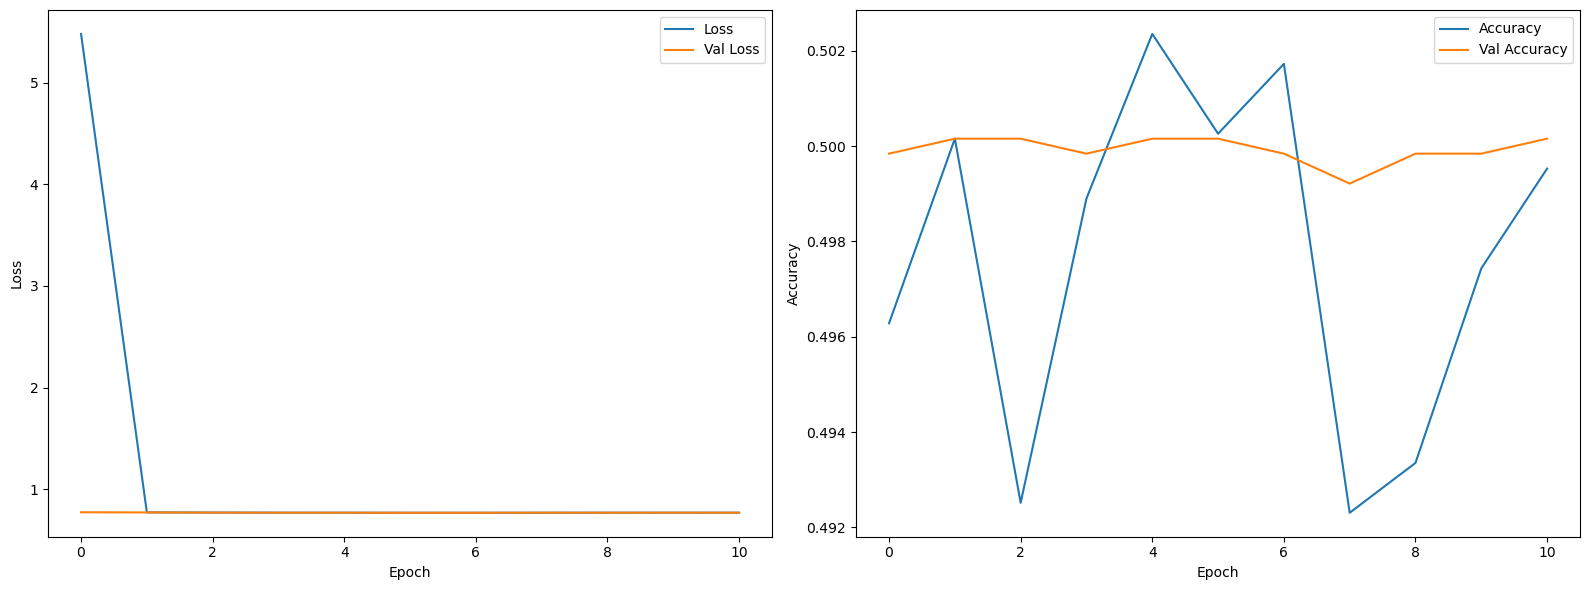

Validation Accuracy :  0.5002
Validation loss:  0.7688
Test Accuracy       :  0.5000
Test loss:  0.7688


2024/05/13 08:48:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 08:48:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps5s0d2at/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_FastText_no_lem_1' already exists. Creating a new version of this model...
2024/05/13 08:48:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_FastText_no_lem_1, version 2
Created version '2' of model 'Keras_lstm_FastText_no_lem_1'.


In [20]:
model_name = "Keras_lstm_FastText_no_lem_1"
embedding_model = FastText(X_train, min_count=1)
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm')

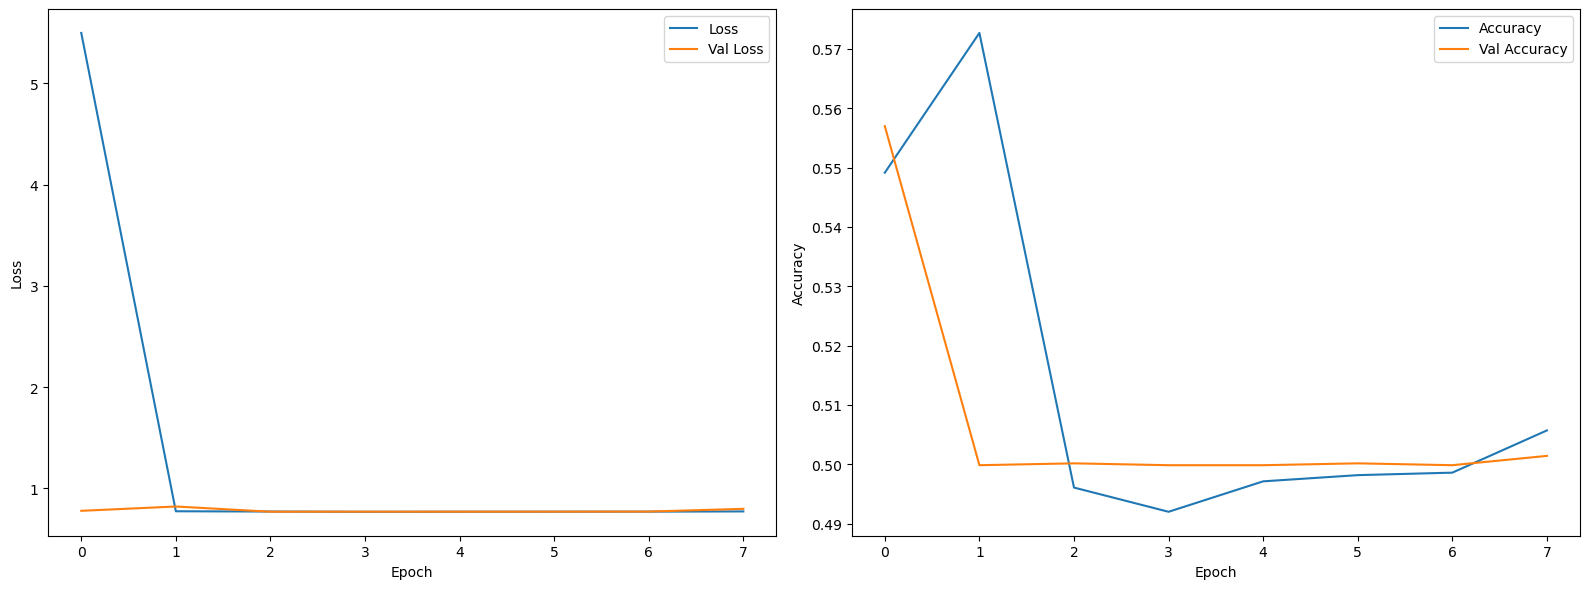

Validation Accuracy :  0.5002
Validation loss:  0.7690
Test Accuracy       :  0.5000
Test loss:  0.7690


2024/05/13 10:35:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 10:36:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdey6o7ug/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_FastText_wiki_news_1' already exists. Creating a new version of this model...
2024/05/13 10:36:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_FastText_wiki_news_1, version 6
Created version '6' of model 'Keras_lstm_FastText_wiki_news_1'.


In [17]:
model_name = "Keras_lstm_FastText_wiki_news_1"
embedding_model = KeyedVectors.load_word2vec_format('../word_embedding/wiki-news-300d-1M-subword.vec', binary=False)
visualize_model_fct(model_name, embedding_model, X_train_lem, X_val_lem, X_test_lem, lstm='lstm', embedding_type='ft')

## Modèle Kera avec embedding Glove

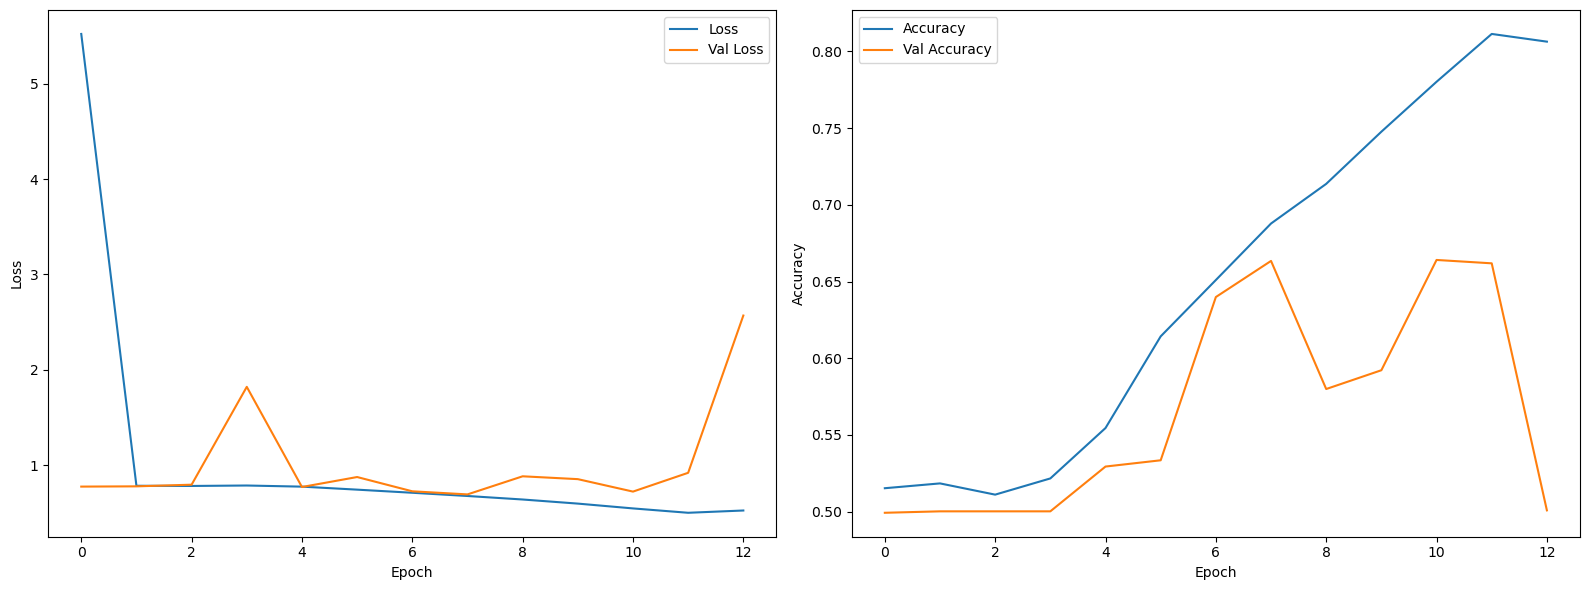

Validation Accuracy :  0.6634
Validation loss:  0.6927
Test Accuracy       :  0.6635
Test loss:  0.6860


2024/05/13 09:08:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 09:09:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt230jb3w/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_Glove_100_1' already exists. Creating a new version of this model...
2024/05/13 09:09:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Glove_100_1, version 2
Created version '2' of model 'Keras_lstm_Glove_100_1'.


In [29]:
model_name = "Keras_lstm_Glove_100_1"
embedding_model = {}
with open('../word_embedding/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='glove')

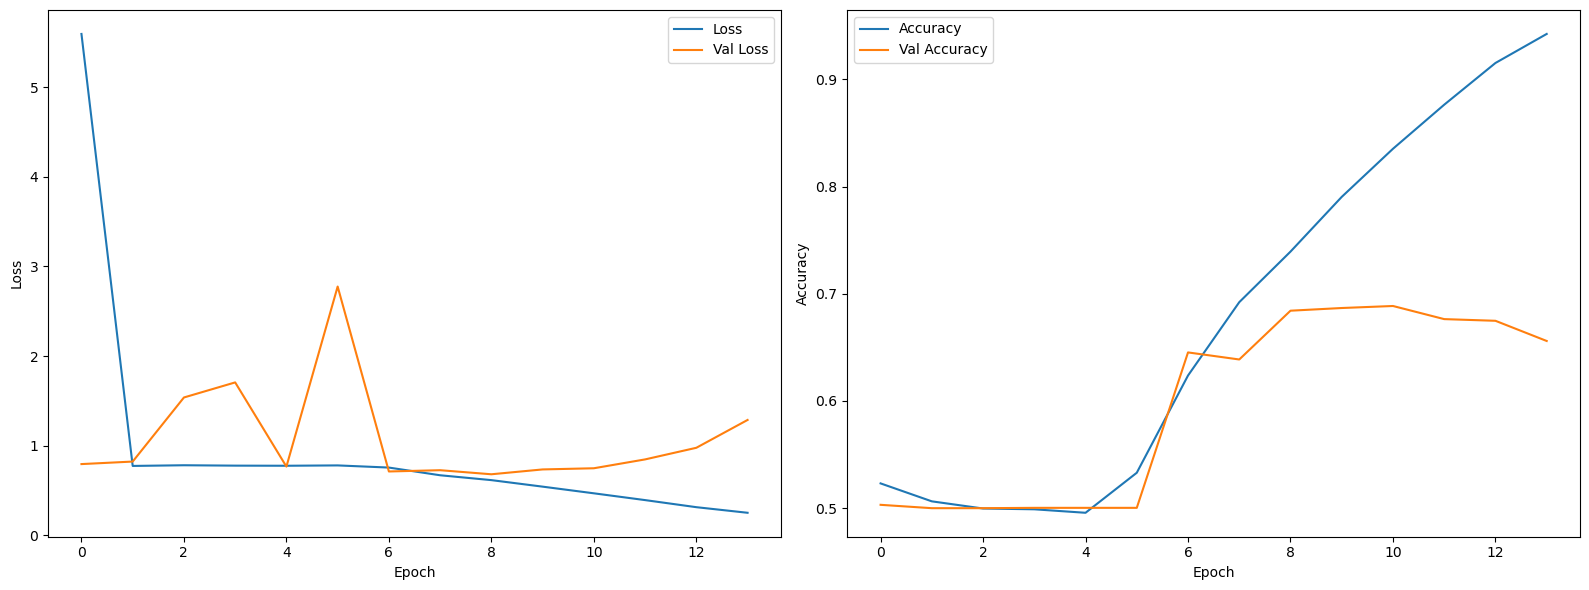

Validation Accuracy :  0.6841
Validation loss:  0.6821
Test Accuracy       :  0.6946
Test loss:  0.6627


2024/05/13 09:07:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 09:07:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdlar7v17/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_Glove_300_1' already exists. Creating a new version of this model...
2024/05/13 09:07:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Glove_300_1, version 2
Created version '2' of model 'Keras_lstm_Glove_300_1'.


In [28]:
model_name = "Keras_lstm_Glove_300_1"
embedding_model = {}
with open('../word_embedding/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='glove')

2024-05-13 10:19:35.653189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 10:19:35.777498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 10:19:35.777545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 10:19:35.780418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 10:19:35.780460: I external/local_xla/xla/stream_executor

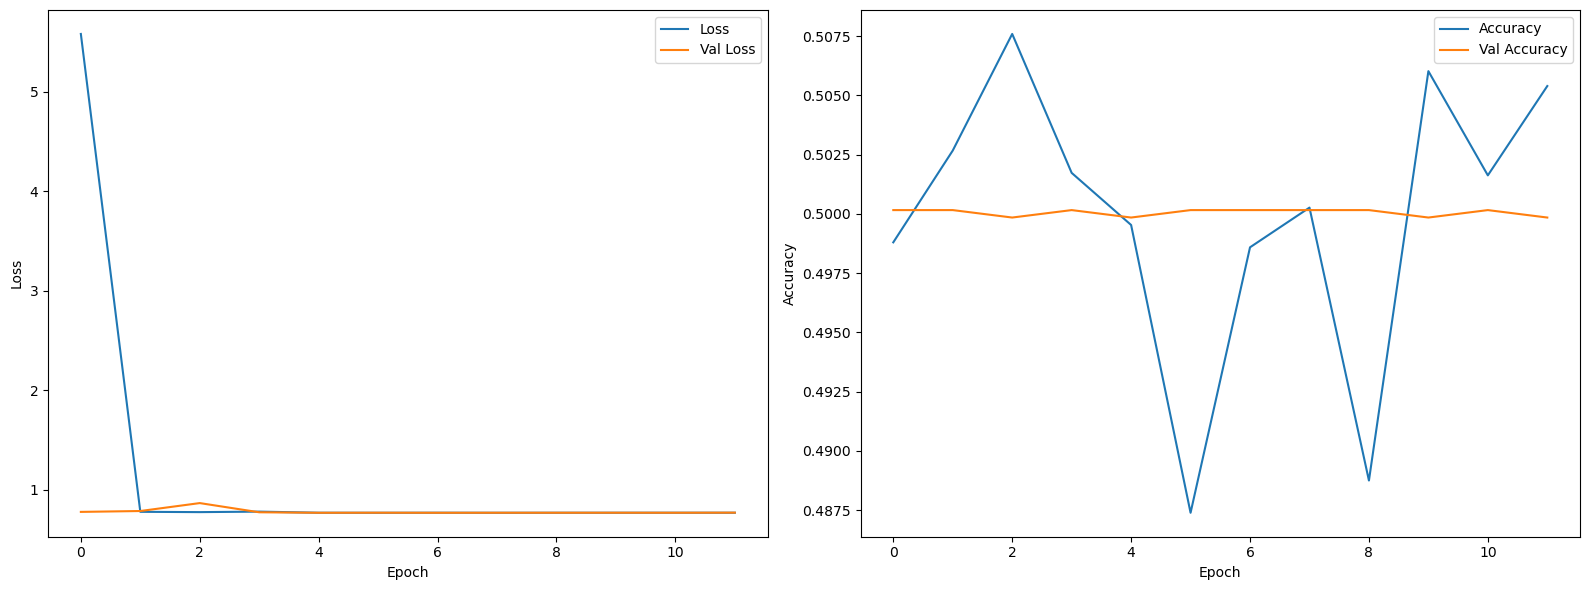

Validation Accuracy :  0.5002
Validation loss:  0.7695
Test Accuracy       :  0.5000
Test loss:  0.7695


2024/05/13 10:20:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 10:20:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxnmwnhm4/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_Glove_tweet_25_1' already exists. Creating a new version of this model...
2024/05/13 10:20:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Glove_tweet_25_1, version 6
Created version '6' of model 'Keras_lstm_Glove_tweet_25_1'.


In [16]:
model_name = "Keras_lstm_Glove_tweet_25_1"
embedding_model = {}
with open('../word_embedding/glove.twitter.27B.25d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='glove')

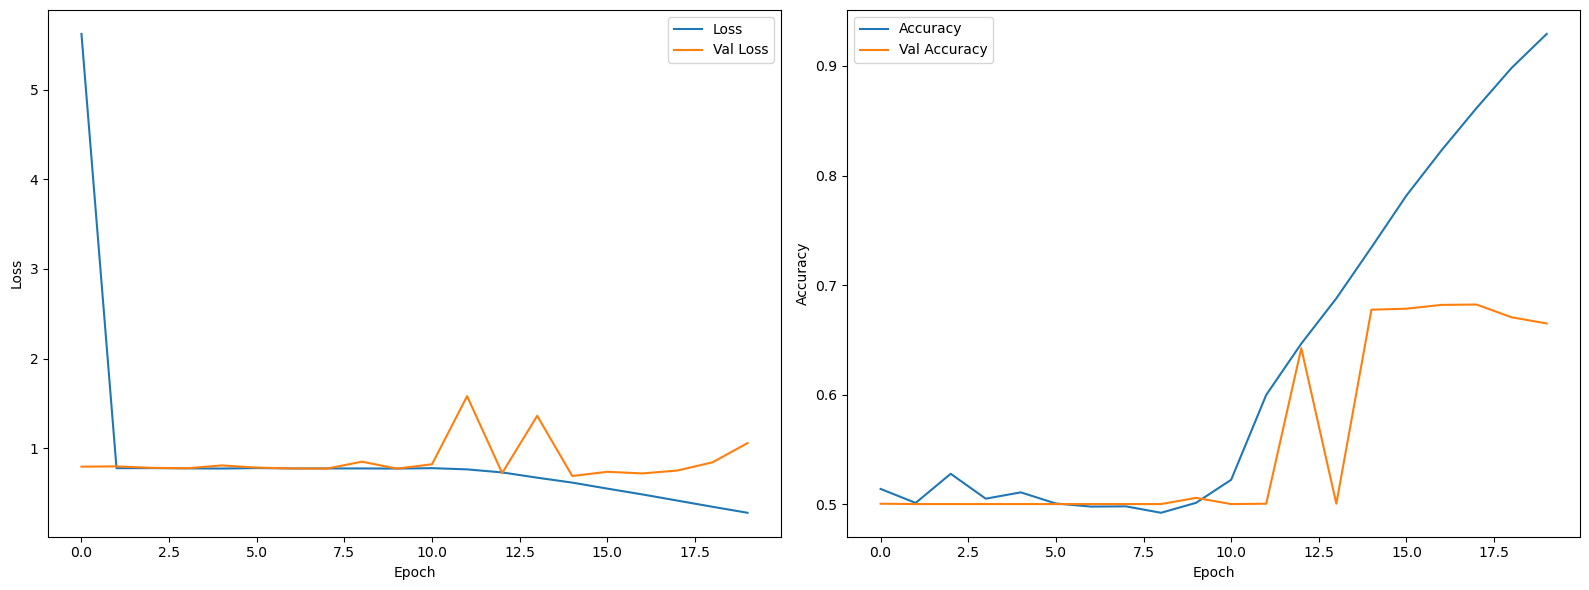

Validation Accuracy :  0.6776
Validation loss:  0.6888
Test Accuracy       :  0.6858
Test loss:  0.6812


2024/05/13 09:01:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/13 09:02:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpo_43pwew/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'Keras_lstm_Glove_tweet_100_1' already exists. Creating a new version of this model...
2024/05/13 09:02:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Glove_tweet_100_1, version 3
Created version '3' of model 'Keras_lstm_Glove_tweet_100_1'.


In [24]:
model_name = "Keras_lstm_Glove_tweet_100_1"
embedding_model = {}
with open('../word_embedding/glove.twitter.27B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='glove')

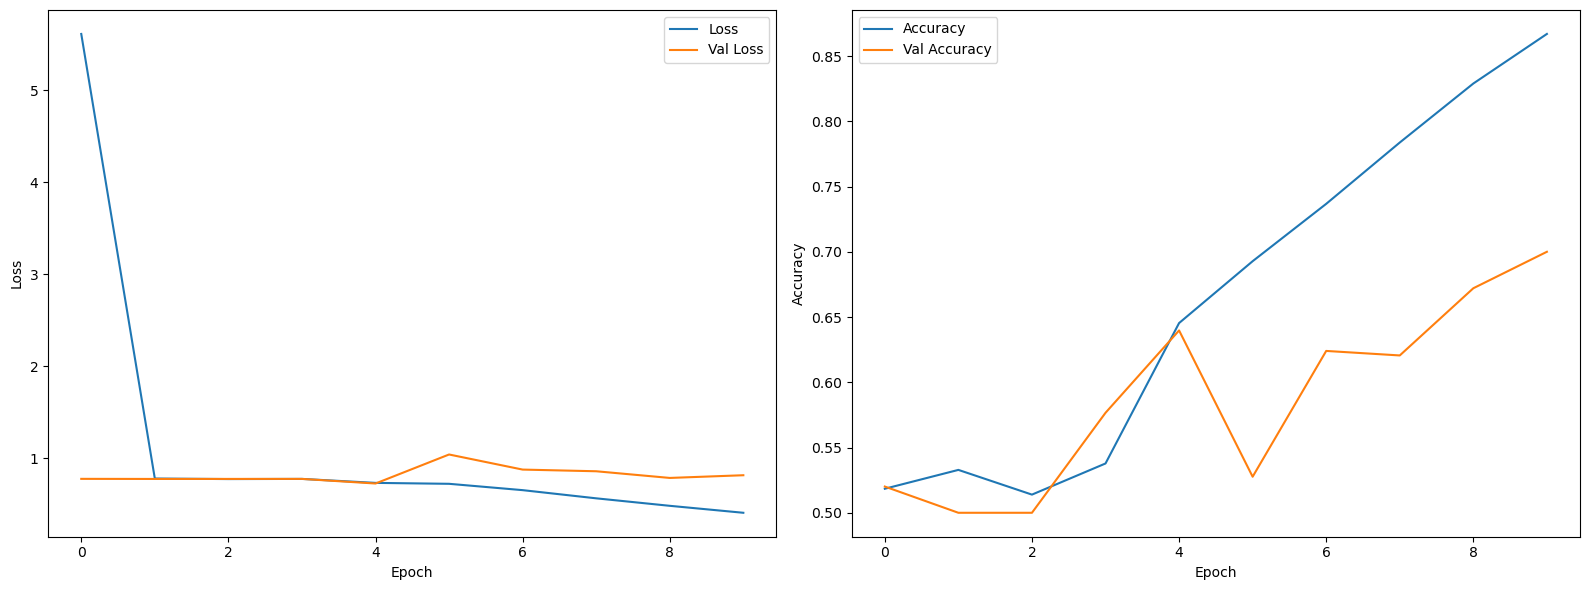

Validation Accuracy :  0.6399
Validation loss:  0.7235
Test Accuracy       :  0.6544
Test loss:  0.7169


2024/05/12 18:10:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/12 18:10:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmd4d36u1/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'Keras_lstm_Glove_tweet_200_1'.
2024/05/12 18:10:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_Glove_tweet_200_1, version 1
Created version '1' of model 'Keras_lstm_Glove_tweet_200_1'.


In [43]:
model_name = "Keras_lstm_Glove_tweet_200_1"
embedding_model = {}
with open('../word_embedding/glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='glove')

## Modèle Kera avec embedding USE

2024-05-13 19:44:25.507014: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


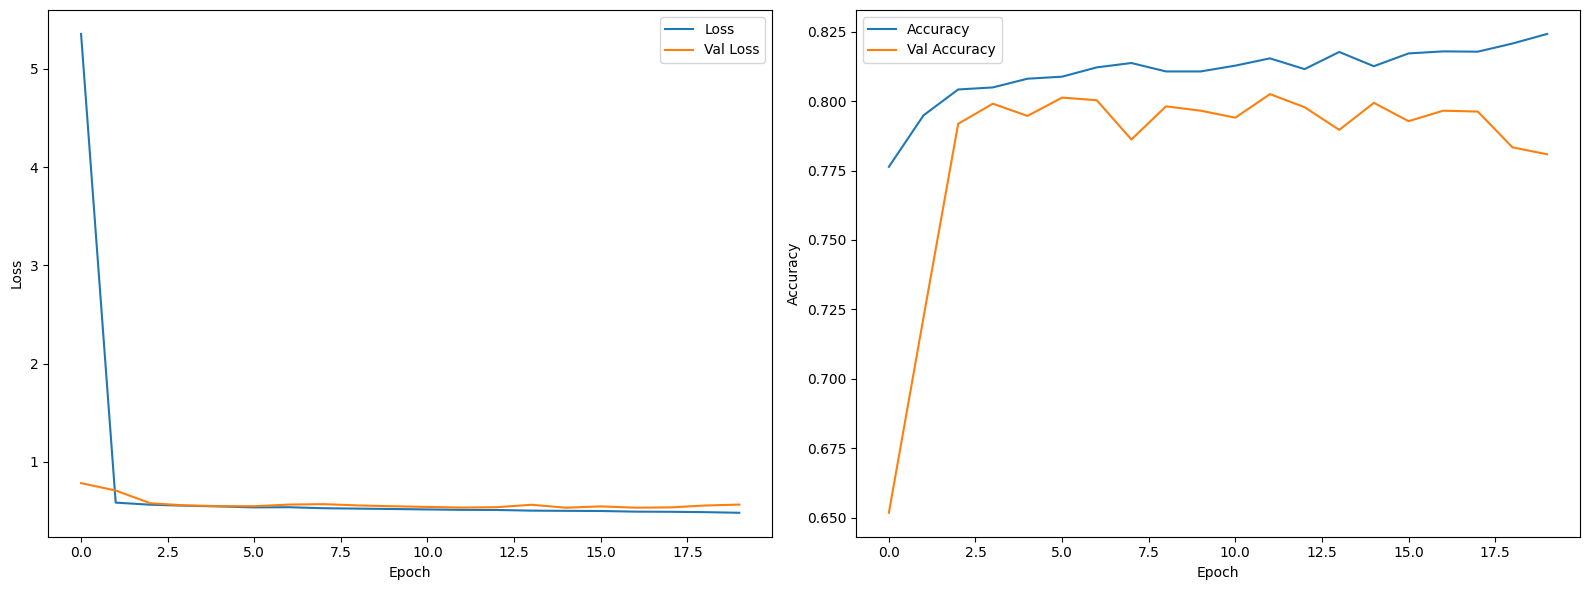

Validation Accuracy :  0.7994
Validation loss:  0.5329
Test Accuracy       :  0.8051
Test loss:  0.5256
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Registered model 'Keras_lstm_USE_1' already exists. Creating a new version of this model...
2024/05/13 19:45:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_lstm_USE_1, version 2
Created version '2' of model 'Keras_lstm_USE_1'.


In [22]:
model_name = "Keras_lstm_USE_1"
embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
visualize_model_fct(model_name, embedding_model, X_train, X_val, X_test, lstm='lstm', embedding_type='use')    

## Modèle BERT

In [45]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, BertForSequenceClassification, BertTokenizer,get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Bert Fonctions

Special_tokens : 
* C'est une représentation d'une unité de texte. Cela peut être aussi simple qu'un mot ou aussi complexe qu'un sous-mot, selon le tokenizer utilisé.
    * CLS : jeton est toujours ajouté au début d'une séquence de texte.
    * SEP :jeton est utilisé pour marquer la fin d'une phrase ou la séparation entre deux phrases

Masques d'attention : 
* Les masques d'attention sont utilisés pour indiquer quels jetons sont des jetons de padding et quels jetons sont de vrais jetons, afin que le modèle ne tienne pas compte des jetons de padding lors du calcul de l'attention.

Tensor : 
* Classe qui offre de nombreuses opérations similaires à celles des matrices numpy, mais peut également être utilisée sur un GPU pour accélérer les calculs.

TensorDataset: 
* Utilisé pour emballer ensemble plusieurs tenseurs de données en un seul objet qui peut être utilisé comme un ensemble de données.

DataLoader: 
* Fournit des fonctionnalités telles que le chargement des données en mémoire par lots (batch), ce qui est essentiel lors de l'entraînement de modèles sur de grands ensembles de données, et le mélange des données (si shuffle=True est défini lors de l'initialisation du DataLoader). Il peut également effectuer des opérations en parallèle pour améliorer les performances, comme le chargement des données en utilisant plusieurs processus (si num_workers > 0 est défini lors de l'initialisation du DataLoader).
    * Shuffle = True : l'ordre des exemples d'entraînement change à chaque époque
    * num_workers > 0 : charger les données en utilisant plusieurs sous-processus

In [46]:
# Fonction de preprocessing du texte
def bert_preprocess_text_fct(text, max_length):
    # Nettoyage du texte
    text = re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)  # Supprimer les URL
    text = re.sub(r'@\w*', '', text)  # Supprimer les mentions
    text = re.sub(r'#', '', text)  # Supprimer les hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces excessifs

    # Tokenisation, conversion en identifiants de jetons et padding
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Ajouter les jetons spéciaux [CLS] et [SEP]
        max_length=max_length,  # Longueur maximale des séquences
        padding='max_length',  # Ajouter des padding
        return_attention_mask=True,  # Retourner les masques d'attention
        truncation=True  # Tronquer les séquences trop longues
    )

    return inputs['input_ids'], inputs['attention_mask']

In [47]:
# Fonction de création des tensors et dataloaders
def bert_prepare_dataloader_fct(X, y, preprocess_func, batch_size, max_length):
    inputs = [preprocess_func(tweet, max_length) for tweet in X] # Prétraiter les tweets
    input_ids = torch.tensor([i[0] for i in inputs]) # Créer un tensor pour les identifiants de jetons
    attention_masks = torch.tensor([i[1] for i in inputs]) # Créer un tensor pour les masques d'attention
    y_tensor = torch.tensor(y.values) # Créer un tensor pour les labels
    data = TensorDataset(input_ids, attention_masks, y_tensor)
    dataloader = DataLoader(data, batch_size=batch_size)
    return dataloader

In [48]:
# Afficher l'évolution des performances lors de l'entrainement
def visualize_history_bert(history, train=False):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(history['train_loss'], label='Loss')
        if train == True :
                plt.plot(history['val_loss'], label='Val Loss')
                plt.xlabel('Epoch')
        else :
                plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(history['train_acc'], label='Accuracy')
        if train == True :
                plt.plot(history['val_acc'], label='Val Accuracy')
                plt.xlabel('Epoch')
        else :
                plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [49]:
def bert_process_batch_fct(batch, model, optimizer, phase):
    
    input_ids, attention_mask, labels = batch

    # Déplacer les données vers le GPU
    model = model.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    # Réinitialiser les gradients si le mode est entraînement
    if phase == 'train':
        optimizer.zero_grad()

    with torch.set_grad_enabled(phase == 'train'):
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)

    # Calculer les gradients et effectuer une étape d'optimisation si le mode est entraînement
    if phase == 'train':
        loss.backward()
        optimizer.step()

    # Détacher les tenseurs et les convertir en numpy pour libérer la mémoire du GPU
    loss_item = loss.item()
    preds_np = preds.cpu().numpy()
    labels_np = labels.cpu().numpy()

    # Supprimer les variables pour libérer la mémoire du GPU
    del input_ids, attention_mask, labels, outputs, loss, preds
    torch.cuda.empty_cache()

    return loss_item, preds_np, labels_np

In [50]:
# Fonction d'entraînement et d'évaluation du modèle

def bert_utilise_model_fct(model, dataloader, optimizer, scheduler=None, phase=None, eval_steps=None, model_save_path=None, patience=5):
    
    # Changer le mode du modèle en mode entraînement ou évaluation
    if phase == 'train':
        model.train()
        history_bert_train = {'train_loss': [], 'train_acc': []}
    else:
        model.eval()
    
    # Initialiser les variables pour le calcul de la perte et de l'exactitude
    loss_total = 0
    preds_list, true_list = [], []

    # Initialiser les variables pour le callback
    steps_no_improve = 0
    step_counter = 1
    best_loss = float('inf')


    # Effectuer chaque step
    # -----------------------------------------------

    for batch in dataloader:

        batch_loss, batch_preds, batch_labels = bert_process_batch_fct(batch, model, optimizer, phase)
            
        # Mettre à jour la barre de progression avec la perte du lot actuel
        dataloader.set_postfix({'batch_loss': batch_loss}, refresh=True)
        dataloader.update()

        loss_total += batch_loss
        preds_list.extend(batch_preds)
        true_list.extend(batch_labels)

        if phase == 'train':
            avg_loss = loss_total / step_counter
            acc= accuracy_score(true_list, preds_list)
            history_bert_train['train_loss'].append(avg_loss)
            history_bert_train['train_acc'].append(acc)

            # Callback pour les steps 
            if eval_steps is not None and step_counter % eval_steps == 0:
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    torch.save(model.state_dict(), model_save_path)
                    steps_no_improve = 0
                else:
                    steps_no_improve += 1
                    if steps_no_improve == patience:
                        return avg_loss, acc, history_bert_train, True

        # Mettre à jour le nombre de steps
        step_counter += 1

    # Calculer la perte moyenne et l'exactitude
    avg_loss = loss_total / len(dataloader)
    acc = accuracy_score(true_list, preds_list)
    if phase == 'train':
        return avg_loss, acc, history_bert_train, False
    else :
        return avg_loss, acc, False

In [51]:
def bert_create_history_fct(model, train_dataloader, val_dataloader, optimizer, epochs, model_save_path="./data/model_best_weights_bert.pth"):
    
    # Initialiser le meilleur loss à l'infini
    best_val_loss = float('inf')
    # Définir le nombre d'époques sans amélioration avant d'arrêter
    patience = 5
    epochs_no_improve = 0
    # Initialiser les listes pour stocker les losses et les accuracies
    history_bert = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


    # Définir le scheduler
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
    

    # Entrainer le modèle
    for epoch in range(epochs):

        for phase, dataloader in [('train', train_dataloader), ('val', val_dataloader)]:
            progress = tqdm(dataloader, desc=phase, leave=False)

            if phase == 'train':
                train_loss, train_acc, history_bert_train, stop_train = bert_utilise_model_fct(model, progress, optimizer, scheduler=scheduler, phase=phase, eval_steps=10, model_save_path=model_save_path)
            else :
                val_loss, val_acc, stop_train = bert_utilise_model_fct(model, progress, optimizer)
                
                # Si la loss de validation est la meilleure jusqu'à présent, sauvegarder le modèle
                if val_loss < best_val_loss:
                    model.to('cpu')
                    torch.save(model.state_dict(), model_save_path)
                    model.to(device)
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        history_bert['train_loss'].append(train_loss)
        history_bert['train_acc'].append(train_acc)
        history_bert['val_loss'].append(val_loss)
        history_bert['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f} ')

        # Si aucune amélioration après 'patience' , arrêter l'entraînement
        if epochs_no_improve == patience | stop_train:
            model.to('cpu')
            torch.cuda.empty_cache()
            return history_bert_train, model_save_path, stop_train     

        # Déplacer le modèle vers la CPU et vider le cache du GPU après chaque époque
        model.to('cpu')
        torch.cuda.empty_cache()

    return history_bert, model_save_path, stop_train 

In [52]:
def bert_eval_model_fct(model, tokenizer, model_name, epochs=50, batch_size=32):

    # Définir où s'effectuera le calcule
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Preprocessing
    #---------------------------------------------------------

    # Préparer les dataloaders
    max_length = max(len(sentence.split()) for sentence in X_train)

    train_dataloader = bert_prepare_dataloader_fct(X_train, y_train, bert_preprocess_text_fct, batch_size, max_length)
    val_dataloader = bert_prepare_dataloader_fct(X_val, y_val, bert_preprocess_text_fct, batch_size, max_length)
    test_dataloader = bert_prepare_dataloader_fct(X_test, y_test, bert_preprocess_text_fct, batch_size, max_length)



    # Entrainer le modèle
    #---------------------------------------------------------

    # Définir l'optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

    # Créer l'history
    history, model_save_path, stop_train = bert_create_history_fct(model, train_dataloader, val_dataloader, optimizer, epochs)

    if stop_train == False:
        visualize_history_bert(history)
    else :
        visualize_history_bert(history, train=True)

    # Tester le modèle sur l'ensemble de test
    #---------------------------------------------------------
    
    # Charger les poids du meilleur modèle
    model.load_state_dict(torch.load(model_save_path))

    start_time = time.time()
    test_progress = tqdm(test_dataloader, desc='Validation', leave=False)
    test_loss, test_acc, _ = bert_utilise_model_fct (model, test_progress, optimizer)
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
    # Prédire les labels et enregistrer le temps de prédiction
    prediction_time_per_tweet = (time.time() - start_time) / len(y_test)



    # sauvegarder le modèle dans mlFlow
    #---------------------------------------------------------
    with mlflow.start_run(run_name=model_name):

        # Enregistrement des paramètres du modèle
        mlflow.log_params(model.config.to_dict())

        # Enregistrement des résultats
        mlflow.log_metric("accuracy", test_acc)
        mlflow.log_metric("time per prediction", prediction_time_per_tweet)

        # Définir la signature du modèle
        input_schema = Schema([
            ColSpec("long", "input_ids"),
            ColSpec("long", "attention_mask"),
            ColSpec("long", "labels")
        ])
        output_schema = Schema([ColSpec("long", "class")])
        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        # Enregistrement du modèle
        mlflow.pytorch.log_model(
            pytorch_model=model,
            artifact_path=model_name,
            signature=signature,
            registered_model_name=model_name,
    )

#### Evaluate Distillbert

/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50, train loss: 0.5202, val loss: 0.4313, train accuracy: 0.7407, val accuracy: 0.7969 


Epoch 2/50, train loss: 0.4399, val loss: 0.4270, train accuracy: 0.7948, val accuracy: 0.8000 


Epoch 3/50, train loss: 0.3583, val loss: 0.4336, train accuracy: 0.8479, val accuracy: 0.7972 


Epoch 4/50, train loss: 0.3137, val loss: 0.4433, train accuracy: 0.8781, val accuracy: 0.7981 


Epoch 5/50, train loss: 0.2343, val loss: 0.4918, train accuracy: 0.9173, val accuracy: 0.7931 


Epoch 6/50, train loss: 0.1644, val loss: 0.5504, train accuracy: 0.9469, val accuracy: 0.7947 


Epoch 7/50, train loss: 0.1196, val loss: 0.6427, train accuracy: 0.9665, val accuracy: 0.7874 


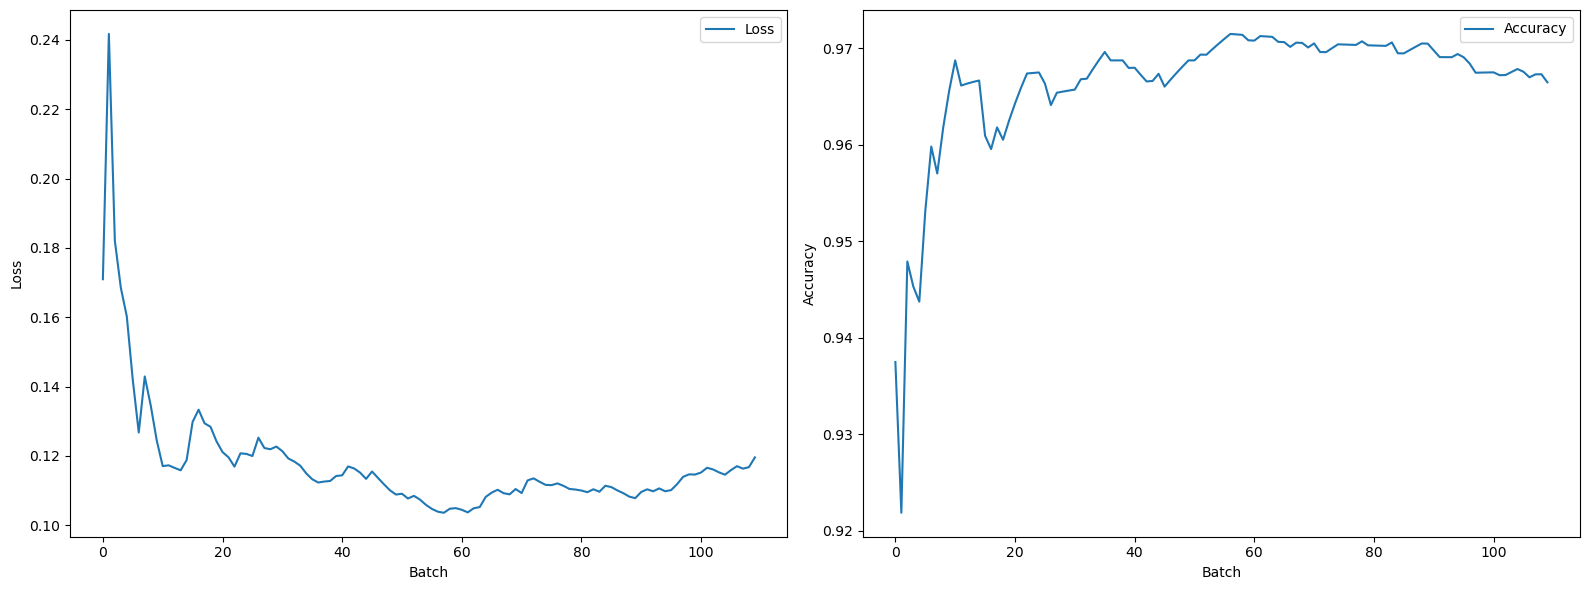

Test loss: 0.6188, Test accuracy: 0.8029


Successfully registered model 'Distillbert_1'.
2024/05/12 20:56:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Distillbert_1, version 1
Created version '1' of model 'Distillbert_1'.


In [53]:
model_name = 'Distillbert_1'
# Charger le modèle BERT pré-entraîné pour la classification de séquences
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# Charger le tokeniseur BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_eval_model_fct(model, tokenizer, model_name)

#### evaluate bert

/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, train loss: 0.5016, val loss: 0.4129, train accuracy: 0.7537, val accuracy: 0.8085 


Epoch 2/2, train loss: 0.4155, val loss: 0.4089, train accuracy: 0.8167, val accuracy: 0.8122 


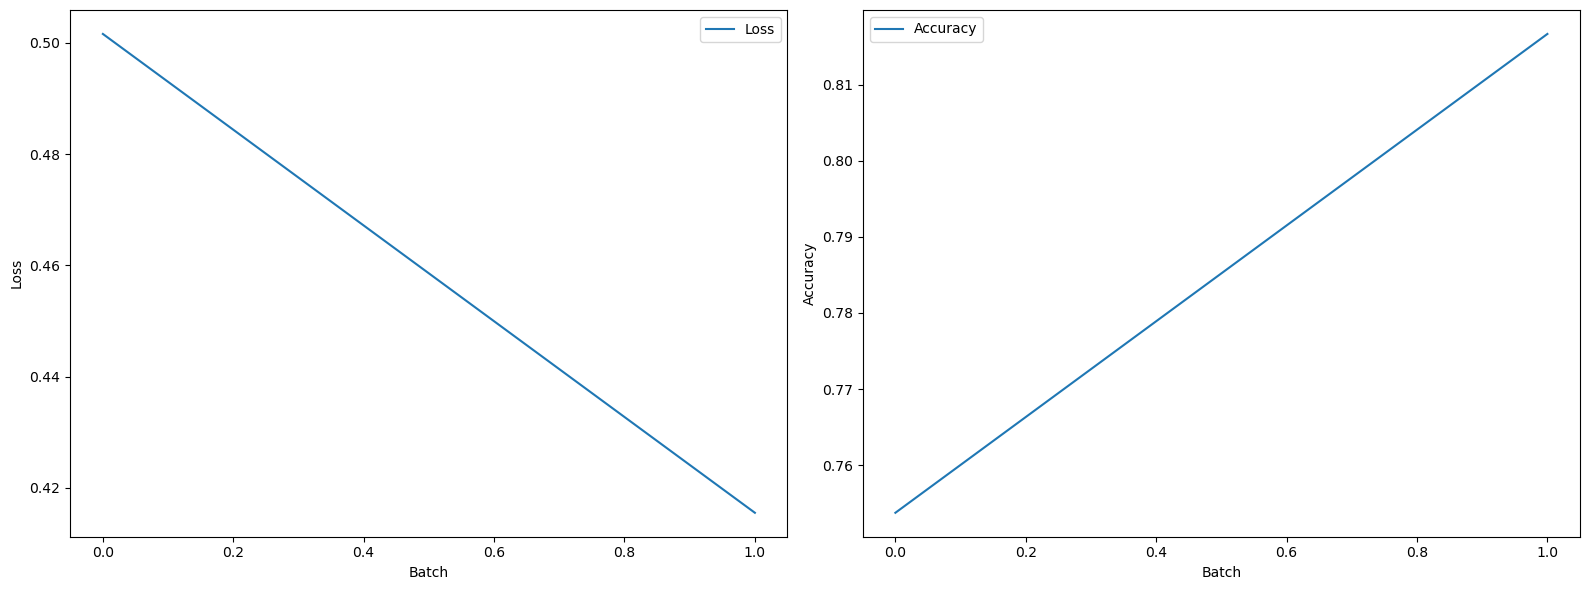

Test loss: 0.3976, Test accuracy: 0.8220


Successfully registered model 'Bert_1'.
2024/05/12 23:14:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bert_1, version 1
Created version '1' of model 'Bert_1'.


In [54]:
model_name = 'Bert_1'
# Charger le modèle BERT pré-entraîné pour la classification de séquences
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
# Charger le tokeniseur BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_eval_model_fct(model, tokenizer, model_name, epochs=2)

## Modèle Roberta

In [55]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
import torch
from torch.utils.data import Dataset

In [56]:
# Charger le modèle et le tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jul/miniconda3/envs/tf/lib/python3.12/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [57]:
# Transformer X_train, X_val, et X_test en des listes de chaînes de caractères
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

# Tokenizer les données
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [58]:
# Préparer les données pour le modèle
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [59]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convertir les labels en torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)

In [60]:
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=3, check_step_interval=10):
        self.patience = patience
        self.check_step_interval = check_step_interval
        self.counter = 0
        self.best_score = None
        self.stop_training = False

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.check_step_interval == 0:  # Check every check_step_interval steps
            if state.log_history:
                if self.best_score is None:
                    self.best_score = state.log_history[-1]['loss']
                elif state.log_history[-1]['loss'] > self.best_score:
                    self.counter += 1
                    if self.counter >= self.patience:
                        self.stop_training = True
                else:
                    self.best_score = state.log_history[-1]['loss']
                    self.counter = 0

            if self.stop_training:
                control.should_training_stop = True

In [61]:
# Créer les datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [62]:
check_steps = 20

# Préparer l'entraînement
training_args = TrainingArguments(
    output_dir='data',                  # répertoire de sortie
    num_train_epochs=20,            
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,                   # nombre de pas d'échauffement pour le taux d'apprentissage
    weight_decay=0.01,                  # intensité de la décroissance du poids
    logging_dir='data',                 # répertoire pour stocker les logs
    logging_steps=check_steps,          # afficher les logs toutes les 10 étapes
)

trainer = Trainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,           
    callbacks=[EarlyStoppingCallback(patience=5, check_step_interval=check_steps)],
)

In [63]:
# Entraîner le modèle
trainer.train()


/tmp/ipykernel_8955/1827429782.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
20,1.362100


KeyboardInterrupt: 

In [89]:
start_time = time.time()
# Faire des prédictions
predictions = trainer.predict(test_dataset)

# Enregistrer le temps de prédiction
prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

# Obtenir les classes prédites
predicted_classes = np.argmax(predictions.predictions, axis=-1)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Test accuracy: {accuracy}')

/tmp/ipykernel_45686/1827429782.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Test accuracy: 0.807909604519774


In [90]:
model_name = 'twitter-roberta-base-sentiment_1'
with mlflow.start_run(run_name= model_name):

        # Enregistrement des paramètres du modèle
        mlflow.log_params(model.config.to_dict())

        # Enregistrement des résultats
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("time per prediction", prediction_time_per_tweet)

        # Définir la signature du modèle
        input_schema = Schema([
            ColSpec("long", "input_ids"),
            ColSpec("long", "attention_mask"),
            ColSpec("long", "labels")
        ])
        output_schema = Schema([ColSpec("float", "class")])
        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        # Enregistrement du modèle
        mlflow.pytorch.log_model(
            pytorch_model=model,
            artifact_path=model_name,
            signature=signature,
            registered_model_name=model_name,
    )

Successfully registered model 'twitter-roberta-base-sentiment_1'.
2024/05/08 12:40:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: twitter-roberta-base-sentiment_1, version 1
Created version '1' of model 'twitter-roberta-base-sentiment_1'.
